BlockSeparation+NonLinearEncoder+LocationEmbedding+UNetdecoder

*5 attempts*

4*4kernel,1:8,EncoderLearning

In [336]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd
import os

In [337]:
from skimage.metrics import structural_similarity as ssim_loss

In [338]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005', 'CIFAR10_NLEtoE_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1224
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\CIFAR10_NLEtoE_result


In [339]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [340]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0),  
                         (1, 1, 1)), 
])

cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [341]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [342]:
def split_into_kernels(image, kernel_size):
    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, c, -1, kernel_size, kernel_size)
    kernels = kernels.permute(0, 2, 1, 3, 4)# (b, n_patches, c, kernel_size, kernel_size)
    return kernels

In [343]:
#EncoderB
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels,alpha=1.2):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        self.alpha = alpha

        kernel_in = kernel_size ** 2 * channels
        self.real_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))
        self.imag_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))

    def forward(self, x):
        b, n_patches, c, k, _ = x.shape# (b, n_patches, c, kernel_size, kernel_size)
        x = x.reshape(b*n_patches, -1)  #(b*p,c*k*k)
        x = torch.exp(1j * self.alpha * x) 
        B = torch.complex(self.real_part, self.imag_part)
        x = x.T  
        x = torch.matmul(B, x).T  #(b*p,c*k*k/l)
        x = torch.abs(x)**2 
        return x, n_patches 
    
    

In [344]:
class PositionalEmbedder(nn.Module):
    def __init__(self, img_size, kernel_size, pos_embed_dim=8):
        super(PositionalEmbedder, self).__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size
        self.pos_embed_dim = pos_embed_dim

        self.num_patches_x = img_size // kernel_size
        self.num_patches_y = img_size // kernel_size


        self.embed_x = nn.Embedding(self.num_patches_x, self.pos_embed_dim)
        self.embed_y = nn.Embedding(self.num_patches_y, self.pos_embed_dim)

    def forward(self, x, b, n_patches):
        #(b*p,c*k*k/l)
       
        patch_ids = torch.arange(n_patches, device=x.device)#全パッチに一意のIDを割り振る。

        ix = patch_ids % self.num_patches_x
        iy = patch_ids // self.num_patches_x

        pos_x = self.embed_x(ix) 
        pos_y = self.embed_y(iy) 

        pos_info = torch.cat([pos_x, pos_y], dim=1) 
        pos_info = pos_info.unsqueeze(0).expand(b, -1, -1).contiguous().view(b*n_patches, -1)

        x = torch.cat([x, pos_info], dim=1) 
        x = x.view(b, n_patches, -1)
        x = x.view(b, -1)
        return x#(b,p*c*k*k/l)

In [345]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch,img_size):
        super(UNetDecoder, self).__init__()

        self.ch = ch

        self.map_pic = img_size//4
        self.fc = nn.Linear(num_in, ch*self.map_pic*self.map_pic)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 3, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        #(b,p*c*k*k/l)
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, self.ch, self.map_pic, self.map_pic) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out#(b,p*c*k*k/l)


In [346]:
def min_max_scale(x, min_val=-1, max_val=1):
    x_min = torch.min(x, dim=1, keepdim=True)[0]  # パッチごとの最小値
    x_max = torch.max(x, dim=1, keepdim=True)[0]  # パッチごとの最大値

    # Min-Maxスケール変換
    x_scaled = (x - x_min) / (x_max - x_min + 1e-8)  # 0～1に正規化（1e-8はゼロ除算防止用）
    x_scaled = x_scaled * (max_val - min_val) + min_val  # min_val～max_valにスケール

    return x_scaled

In [347]:
class AutoEncoder(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage, ch, pos_embed_dim):
        super(AutoEncoder, self).__init__()
        self.kernel_size = kernel_size
        
        self.img_size = img_size
        self.channels = channels
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in/leverage)*channels
        num_patches = (img_size//kernel_size)*(img_size//kernel_size)
        total_dim = num_patches*(feat_dim + 2*pos_embed_dim)
        self.pos_embed_dim = pos_embed_dim
        
        self.encoder = Encoder(kernel_size,leverage,channels)
        self.pos_embedder = PositionalEmbedder(img_size,kernel_size,pos_embed_dim)  
        self.decoder = UNetDecoder(total_dim, ch, img_size, )
    def forward(self, x):
        x = x.view(x.size(0), self.channels, self.img_size, self.img_size)  
        x = split_into_kernels(x, self.kernel_size) 
        x,n_patches = self.encoder(x) #(b*p,c*k*k/l)
        '''output_min = torch.min(x).item()  # 最小値
        output_max = torch.max(x).item()  # 最大値

        print(f"出力レンジ: 最小値={output_min}, 最大値={output_max}")'''
        x = min_max_scale(x)
        

        b = x.size(0)//n_patches
        x = self.pos_embedder(x,b,n_patches)#(b,p*c*k*k/l)
        x_reconstructed = self.decoder(x)#(b,p*c*k*k/l)
        return x_reconstructed#(b,p*c*k*k/l)

In [348]:
#CIFAR-10の画像を表示する関数
def show_images(images, labels, title):
    images = images.view(images.size(0), 3, 32, 32)
    fixed_indices = {1: 1, 3: 3, 5: 1} 
    selected_classes = [1, 3, 5]  # airplane, cat, dog
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
    images = images.numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0, 0, 0])
    std = np.array([1, 1, 1])
    images = images * std + mean
    images = np.clip(images, 0, 1) 
    
    num_classes = len(selected_classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    
    for i, cls in enumerate(selected_classes):
        matching_indices = (labels == cls).nonzero(as_tuple=True)[0]
        if cls in fixed_indices:
            fixed_index = fixed_indices[cls]
            if fixed_index < len(matching_indices):
                img_idx = matching_indices[fixed_index]
                img = images[img_idx]
                ax = axes[i] if num_classes > 1 else axes
                ax.imshow(img)
                ax.set_title(class_names[cls])
                ax.axis('off')
            else:
                print(f"クラス {class_names[cls]} に指定されたインデックス {fixed_index} が見つかりません。")
        else:
            print(f"クラス {class_names[cls]} の固定インデックスが指定されていません。")
    plt.suptitle(title)

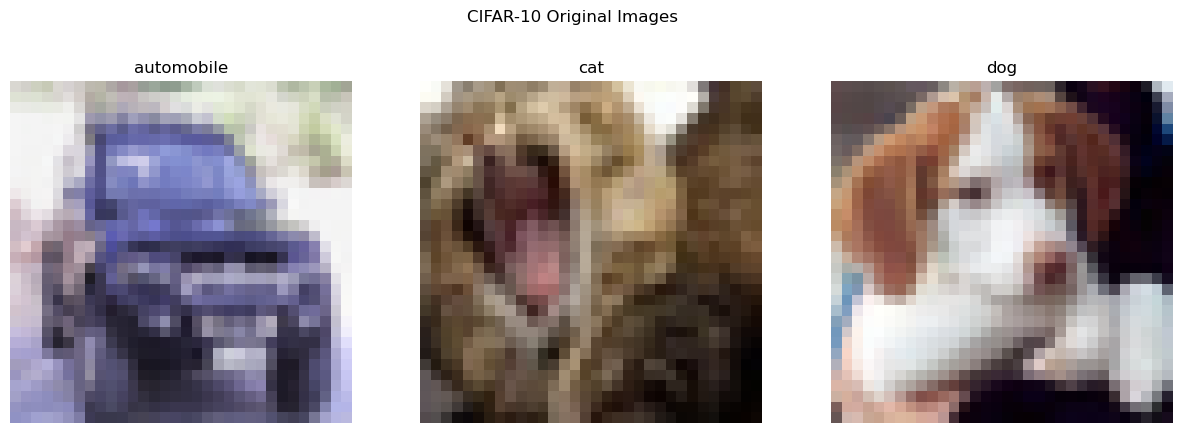

In [349]:

for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")  
    break
plt.show()

1/1th Time Epoch: 1/30

train_loss 0.05063967492974475
test_loss: 0.033718837990979605
Time 19.336344957351685
SSIM 0.5729282807700241


1/1th Time Epoch: 2/30

train_loss 0.03027485309602202
test_loss: 0.0281450215821402
Time 19.17380452156067
SSIM 0.6652756212632868


1/1th Time Epoch: 3/30

train_loss 0.026173517565288202
test_loss: 0.024863375162210644
Time 19.28132438659668
SSIM 0.7086146556878392


1/1th Time Epoch: 4/30

train_loss 0.024030018216737396
test_loss: 0.02340288097156754
Time 19.14929461479187
SSIM 0.7305391868458518


1/1th Time Epoch: 5/30

train_loss 0.022542063156357203
test_loss: 0.02235577976967715
Time 19.17580485343933
SSIM 0.7474711937240407


1/1th Time Epoch: 6/30

train_loss 0.021318933876502848
test_loss: 0.0211997803866486
Time 19.1748046875
SSIM 0.7585366119312335


1/1th Time Epoch: 7/30

train_loss 0.020367024313953833
test_loss: 0.020442930910783478
Time 19.174803972244263
SSIM 0.7684052103682409


1/1th Time Epoch: 8/30

train_loss 0.019570232490482536
test_loss: 0.019652775924982904
Time 19.23081660270691
SSIM 0.7800233296201199


1/1th Time Epoch: 9/30

train_loss 0.018948898271983847
test_loss: 0.019167443407298642
Time 19.158295392990112
SSIM 0.7844104857384404


1/1th Time Epoch: 10/30

train_loss 0.018329912739450973
test_loss: 0.01867236237077019
Time 19.027276277542114
SSIM 0.7927210119706166


1/1th Time Epoch: 11/30

train_loss 0.017862529177075762
test_loss: 0.018262668807483926
Time 18.999764680862427
SSIM 0.797026657605473


1/1th Time Epoch: 12/30

train_loss 0.01739072187058151
test_loss: 0.017756969538293307
Time 19.17881965637207
SSIM 0.805821085277992


1/1th Time Epoch: 13/30

train_loss 0.01703446380117589
test_loss: 0.017588504931971997
Time 19.153295516967773
SSIM 0.8046922698805604


1/1th Time Epoch: 14/30

train_loss 0.01665269425067374
test_loss: 0.017299721630502352
Time 19.247319221496582
SSIM 0.8075832271877723


1/1th Time Epoch: 15/30

train_loss 0.016296596154380026
test_loss: 0.017514781531276582
Time 19.217309713363647
SSIM 0.8107950061182433


1/1th Time Epoch: 16/30

train_loss 0.016006657489292
test_loss: 0.017227847812862337
Time 19.109293222427368
SSIM 0.8141345743891559


1/1th Time Epoch: 17/30

train_loss 0.015683695647741674
test_loss: 0.01656864631826742
Time 19.100284099578857
SSIM 0.818929577175575


1/1th Time Epoch: 18/30

train_loss 0.015471063311333242
test_loss: 0.01689505843516392
Time 19.11328649520874
SSIM 0.8194064203696915


1/1th Time Epoch: 19/30

train_loss 0.015238238091263777
test_loss: 0.015990166783427136
Time 19.050773859024048
SSIM 0.8236934550200836


1/1th Time Epoch: 20/30

train_loss 0.014924647901064295
test_loss: 0.016063844737938687
Time 19.07127594947815
SSIM 0.8221906348119808


1/1th Time Epoch: 21/30

train_loss 0.014785864137951523
test_loss: 0.015530279448515252
Time 19.056282997131348
SSIM 0.8285516915442068


1/1th Time Epoch: 22/30

train_loss 0.014563173215236048
test_loss: 0.015554647138224372
Time 19.057282209396362
SSIM 0.8290983725197708


1/1th Time Epoch: 23/30

train_loss 0.014354962045731752
test_loss: 0.01577013214649279
Time 19.14979839324951
SSIM 0.8293739089482948


1/1th Time Epoch: 24/30

train_loss 0.014190390432143913
test_loss: 0.015295808286040644
Time 19.13730025291443
SSIM 0.8333892754361599


1/1th Time Epoch: 25/30

train_loss 0.013930614466023871
test_loss: 0.015650089948049076
Time 19.114792108535767
SSIM 0.8329491064518313


1/1th Time Epoch: 26/30

train_loss 0.013830210954008047
test_loss: 0.015236947874102411
Time 19.172301769256592
SSIM 0.8325334485573105


1/1th Time Epoch: 27/30

train_loss 0.013607404611604599
test_loss: 0.014870177258890642
Time 19.14479637145996
SSIM 0.8377332800551306


1/1th Time Epoch: 28/30

train_loss 0.013484830706073044
test_loss: 0.015087795726766315
Time 19.21931028366089
SSIM 0.8367385034319721


1/1th Time Epoch: 29/30

train_loss 0.01328539629907483
test_loss: 0.01480695196203416
Time 19.109285593032837
SSIM 0.8409268282636811
train_loss 0.013192550288727675
test_loss: 0.014757659958227526
Time 19.028772354125977
SSIM 0.8398349481292918
SSIM: 0.8398349481292918
loss_train: 0.0132,loss_test: 0.0148
MSE: 0.014757659958227526
ProcessingTime: 574.313915014267


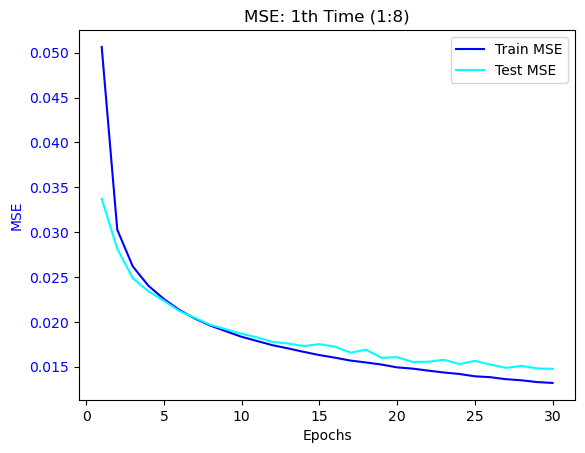

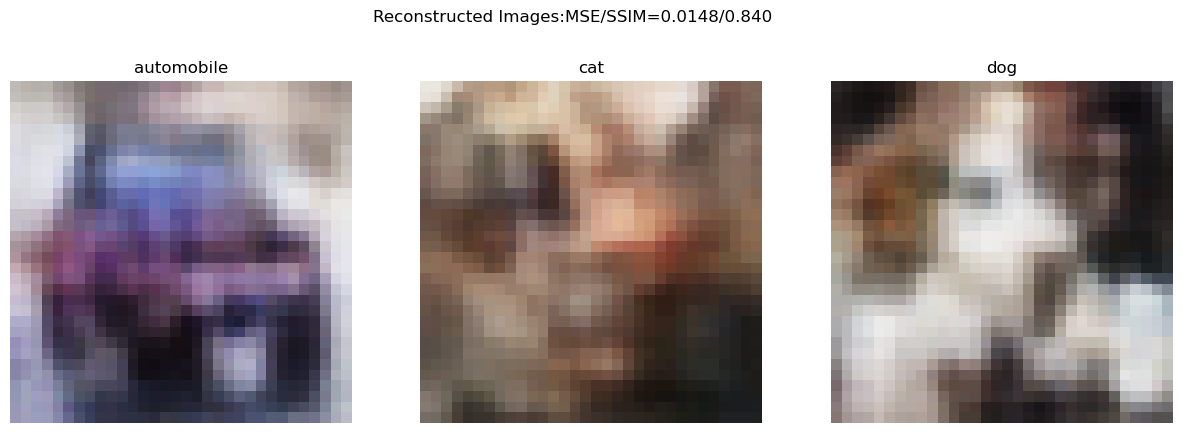

In [350]:

img_size = 32
channels = 3

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 64##64
pos_embed_dim = 8##16
max_epochs = 30#50

num_try = 1##5

All_last_loss = []
All_last_ssim = []
All_loss_test = []
All_pro_time = []


for num_times in range(num_try): 

    model = AutoEncoder(img_size,channels,kernel_size,leverage,ch,pos_embed_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0
        ssim_test_0=0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            
            loss = criterion(y, x.view(x.size(0), -1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, x.view(x.size(0), -1))
                ssim_test0 = ssim_loss(y.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                  x.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                  channel_axis=-1,data_range=1.0)
                loss_test += loss.item()
                ssim_test_0 += ssim_test0

        loss_test_avg = loss_test / len(test_dataloader)
        ssim_test_avg = ssim_test_0 / len(test_dataloader)
        print('train_loss',loss_train_avg)
        print('test_loss:',loss_test_avg)
        print('Time',end_time1-start_time1)
        print('SSIM',ssim_test_avg)
        
        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        
        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            All_last_ssim.append(ssim_test_avg) 
    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    print('SSIM:',ssim_test_avg)
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print("MSE:",Last_loss_test)
    print('ProcessingTime:',sum(pro_time_))

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'MSE: %dth Time (1:%d)'%(num_times+1,leverage) #
    plt.title(title)
    file_name = '%d_%dth(1_%d)_mse.png'%(int(formatted_date),num_times+1,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

    with torch.no_grad():
        test_images = test_images.to(device)
        reconstructed_images = model(test_images)
        image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test_avg)
        show_images(reconstructed_images.cpu(),test_labels, image_title)
        file_name = '%d_ReImage%dth(1_%d).png'%(int(formatted_date),num_times+1,leverage)
        full_path = os.path.join(save_directory, file_name)
        plt.savefig(full_path, dpi=100, bbox_inches='tight')
        plt.show()




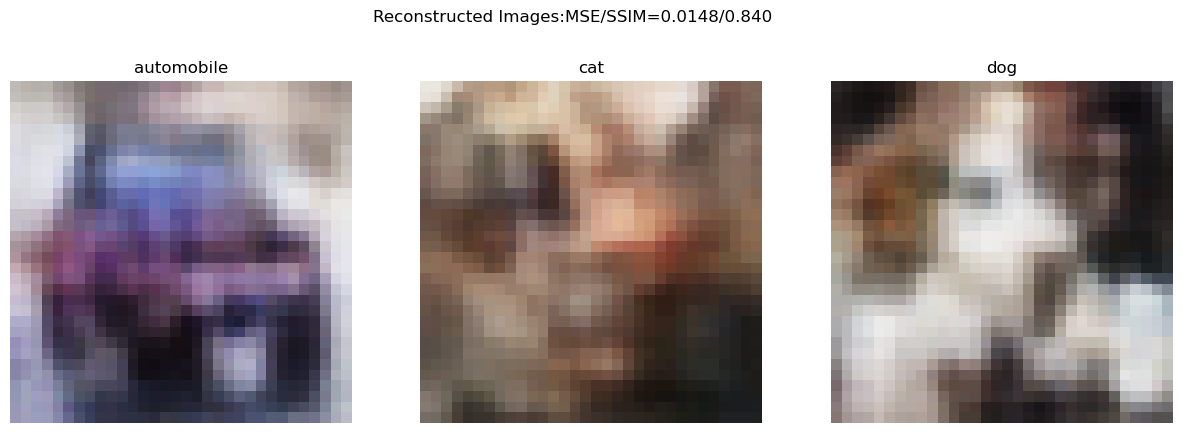

In [351]:
with torch.no_grad():
    test_images = test_images.to(device)
    reconstructed_images = model(test_images)
    image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test_avg)
    show_images(reconstructed_images.cpu(),test_labels, image_title)
    file_name = '%d_ReImage%dth(1_%d).png'%(int(formatted_date),num_times+1,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

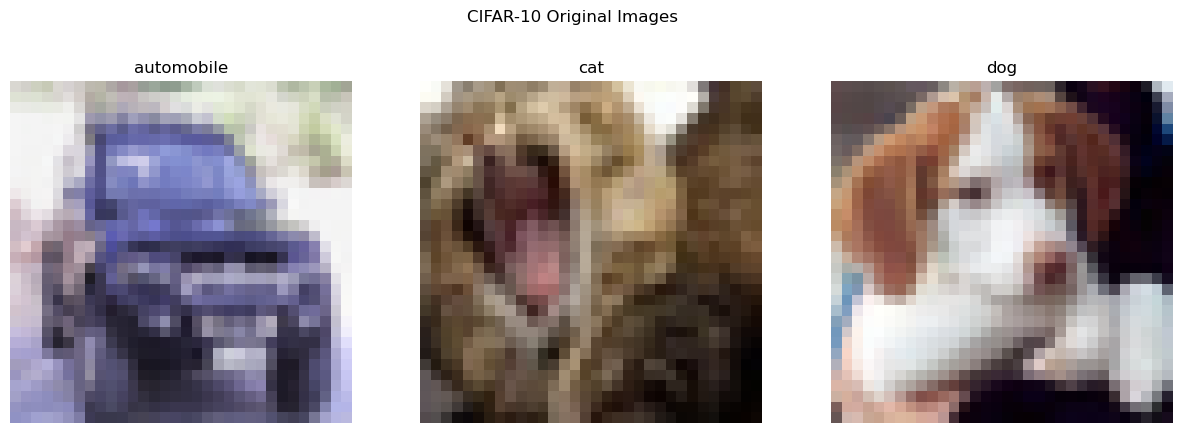

In [352]:
for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")             
    break
plt.show()

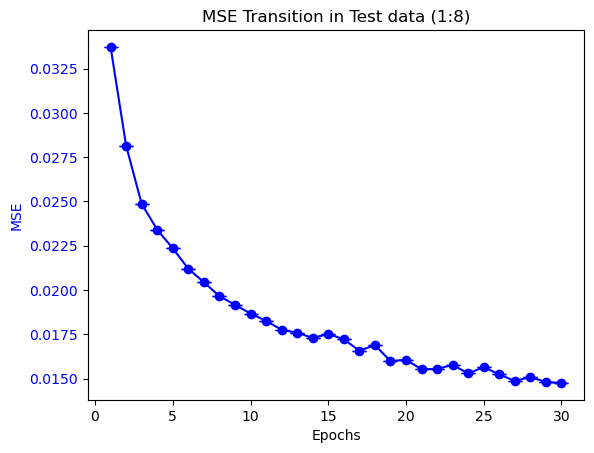

In [353]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)
file_name = '%d_MSE_errorbar.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

plt.show()

In [354]:
import csv
SSIM_mean = np.mean(All_last_ssim)
SSIM_best = np.max(All_last_ssim)
SSIM_bestID = np.argmax(All_last_ssim)+1
SSIM_worst = np.min(All_last_ssim)
SSIM_worstID = np.argmin(All_last_ssim)+1

MSE_mean = np.mean(All_last_loss)
MSE_best = np.min(All_last_loss)
MSE_bestID = np.argmin(All_last_loss)+1
MSE_worst = np.max(All_last_loss)
MSE_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["SSIM", "MSE"],
    "Average": [SSIM_mean, MSE_mean],
    "Best ID": [SSIM_bestID, MSE_bestID],
    "Best": [SSIM_best, MSE_best],
    "Worst ID": [SSIM_worstID, MSE_worstID],
    "Worst": [SSIM_worst, MSE_worst],
}

df = pd.DataFrame(data)

print(df)

file_name = '%d_exTable.csv'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
df.to_csv(full_path, index=False)

          Average  Best ID      Best  Worst ID     Worst
0  SSIM  0.839835        1  0.839835         1  0.839835
1   MSE  0.014758        1  0.014758         1  0.014758


In [355]:
pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)

     Index  Processing Time
0        1       574.313915
   Average       574.313915


In [356]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CIFAR10_NLEtoE_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\texts
